In [2]:
import numpy as np
import matplotlib.pyplot as plt

##############################################
#Generating data points for 3(a) and splitting
##############################################


x = np.linspace(0, 1, 100)
x = x.reshape(-1, 1) # Column vector

# Generate noise from N(0, 0.1)
np.random.seed(0)
noise = np.random.normal(0, np.sqrt(0.1), size=x.shape)

# Compute target values t_n = sin(2πx_n) + ε_n
t = np.sin(2 * np.pi * x) + noise
t = t.reshape(-1, 1) # Column vector


#Take even samples for training and odd samples for testing
x_train = x[::2]
t_train = t[::2]
x_test = x[1::2]
t_test = t[1::2]

In [3]:
#########################################
#Functions to implement kernel regression
#########################################

#Function to calculate the mean squared error
def mean_squared_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.mean((y_true - y_pred) ** 2)

#Function to find the kernel vector with dimensions 100 x M+1
def get_kernel(x, M, kernelType='polynomial', centers=None, sigma=0.1, a=1.0, b=0.0):
    if kernelType == 'gaussian':
        if centers is None:
            raise ValueError("No centers provided")
        centers = np.asarray(centers).reshape(1, -1)
        return np.exp(- (x - centers) ** 2 / (2 * sigma ** 2))

    elif kernelType == 'polynomial':
        return np.hstack([x ** i for i in range(M + 1)])

    elif kernelType == 'sigmoid':
        return np.hstack([np.tanh(a * x + b + i) for i in range(M + 1)])

#Function to estimate the parameters
def KernelRegressionFit(x_train,t_train,kernelType,M,lamda,centers=None, sigma=0.1, a=1.0, b=0.0): #(training data, training targets, type of kernel, regularization coefficient)
    phi = get_kernel(x_train, M, kernelType, centers, sigma,a,b)
    I = np.eye(phi.shape[1])
    w_opt = np.linalg.inv(phi.T @ phi + lamda * I) @ phi.T @ t_train #obtain optimal weights
    return w_opt

#Function to compute the training and testing errors from the current weight estimates
def KernelRegressionPred_Error(w_est, x_train, t_train, x_test, t_test, kernelType, M,centers=None, sigma=0.1, a=1.0, b=0.0):
    # Find kernel matrices
    Phi_train = get_kernel(x_train, M, kernelType, centers, sigma, a, b)
    Phi_test = get_kernel(x_test, M, kernelType, centers, sigma, a, b)

    # Predictions
    t_train_pred = Phi_train @ w_est
    t_test_pred = Phi_test @ w_est

    # Compute MSE
    train_error = mean_squared_error(t_train, t_train_pred)
    test_error = mean_squared_error(t_test, t_test_pred)

    return train_error, test_error

### Kernel Regression Functions
`mean_squared_error`: Computes the mean squared error between true and predicted values.

`get_kernel`: Generates the design matrix for kernel regression using polynomial, Gaussian, or sigmoidal basis functions.

`KernelRegressionFit`: Fits a kernel regression model by estimating weights using regularized least squares.

`KernelRegressionPred_Error`: Calculates training and testing mean squared errors using the learned model weights.


In [4]:
######################################################################################
#Functions to find best parameters for each type of kernel for a particular value of M
######################################################################################

def tune_sigmoid(x_train, t_train, x_test, t_test, M,
                        lambda_values, a_values, b_values):
    best_params = {}
    best_mse = float('inf')

    for lam in lambda_values:
        for a in a_values:
            for b in b_values:
                try:
                    w_est = KernelRegressionFit(
                        x_train, t_train, kernelType='sigmoid',
                        M=M, lamda=lam, a=a, b=b
                    )
                    _, test_err = KernelRegressionPred_Error(
                        w_est, x_train, t_train, x_test, t_test,
                        kernelType='sigmoid', M=M, a=a, b=b
                    )
                    if test_err < best_mse:
                        best_mse = test_err
                        best_params = {'lambda': lam, 'a': a, 'b': b}
                except Exception as e:
                    continue
        
    print(f"Best sigmoid kernel: a={best_params['a']}, b={best_params['b']}, lambda={best_params['lambda']}")
    print(f"Test MSE: {best_mse:.4f}")

    return best_params, best_mse

#Function to find the best parameters for gaussian
def tune_sigma(x_train, t_train, x_test, t_test, M,
                         lambda_values, sigma_values):
    best_params = {}
    best_mse = float('inf')

    for lam in lambda_values:
        for sigma in sigma_values:
            centers = np.linspace(x_train.min(), x_train.max(), M + 1)
            try:
                w_est = KernelRegressionFit(
                    x_train, t_train, kernelType='gaussian',
                    M=M, lamda=lam, centers=centers, sigma=sigma
                )
                _, test_err = KernelRegressionPred_Error(
                    w_est, x_train, t_train, x_test, t_test,
                    kernelType='gaussian', M=M,
                    centers=centers, sigma=sigma
                )
                if test_err < best_mse:
                    best_mse = test_err
                    best_params = {'lambda': lam, 'sigma': sigma}
            except Exception as e:
                continue
    print(f"Best Gaussian kernel params: lambda={best_params['lambda']}, sigma={best_params['sigma']}")
    print(f"Test MSE: {best_mse:.4f}")      

    return best_params, best_mse

#Function to find the best parameters for polynomial
def tune_polynomial(x_train, t_train, x_test, t_test, M, lambda_values):
    best_lambda = None
    best_test_error = float('inf')

    for lamda in lambda_values:
        # Fit model
        w_est = KernelRegressionFit(x_train, t_train, 'polynomial', M, lamda)
        
        # Evaluate error
        train_err, test_err = KernelRegressionPred_Error(
            w_est, x_train, t_train, x_test, t_test, 'polynomial', M
        )
        if test_err < best_test_error:
            best_test_error = test_err
            best_lambda = lamda

    print(f"Best λ for Polynomial Kernel = {best_lambda:.5f} with Test Error = {best_test_error:.4f}")
    return best_lambda



### Kernel Parameter Tuning Functions

These functions perform hyperparameter tuning for different kernel types by evaluating combinations of parameter values and selecting the set that minimizes test mean squared error (MSE):

- `tune_sigmoid(...)` searches over `a`, `b`, and `lambda` for the sigmoidal kernel.
- `tune_sigma(...)` searches over `sigma` and `lambda` for the Gaussian kernel.
- `tune_polynomial(...)` searches over `lambda` for the polynomial kernel.


In [5]:
#########################################
#Functions to plot predictions and errors
#########################################

# Function to plot predictions for a particular order
def PlotPrediction(x_vis, x_train, t_train, x_test, t_test, M, lamda, centers, sigma, a, b, best_sigmoid,best_gaussian,best_poly):
    kernel_types = ['polynomial', 'gaussian', 'sigmoid']
    
    plt.figure(figsize=(15, 4))
    for i, kernel in enumerate(kernel_types):
        # Fit model
        if(kernel == 'sigmoid'):
            lamda = best_sigmoid['lambda']
            a = best_sigmoid['a']
            b = best_sigmoid['b']
            
        elif(kernel == 'gaussian'):
            lamda = best_gaussian['lambda']
            sigma = best_gaussian['sigma']
        
        elif(kernel == 'polynomial'):
            lamda = best_poly
    
        w_est = KernelRegressionFit(x_train, t_train, kernel, M, lamda,
                                    centers=centers, sigma=sigma, a=a, b=b)
        
        # Get predictions
        Phi_vis = get_kernel(x_vis, M, kernel, centers=centers, sigma=sigma, a=a, b=b)
        y_vis = Phi_vis @ w_est
        # Compute errors
        train_err, test_err = KernelRegressionPred_Error(
            w_est, x_train, t_train, x_test, t_test, kernel, M,
            centers=centers, sigma=sigma, a=a, b=b
        )

        # Plot
        plt.subplot(1, 3, i + 1)
        plt.title(f'{kernel.capitalize()} Kernel\nTrain MSE: {train_err:.4f}, Test MSE: {test_err:.4f}')
        plt.plot(x_vis, y_vis, label='Model prediction', color='red')
        plt.scatter(x_train, t_train, label='Train data', color='blue', s=10)
        plt.scatter(x_test, t_test, label='Test data', color='green', marker='x', s=10)
        plt.ylim(-2, 2)
        plt.xlabel('x')
        if i == 0:
            plt.ylabel('t')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot errors for a particular M
def PlotErrors(x_train, t_train, x_test, t_test, lamda, sigma, a, b, M_range,best_sigmoid,best_gaussian,best_poly):
    kernel_types = ['polynomial', 'gaussian', 'sigmoid']

    # Error containers
    error_dict = {
        'polynomial': {'train': [], 'test': []},
        'gaussian': {'train': [], 'test': []},
        'sigmoid': {'train': [], 'test': []}
    }

    for kernel in kernel_types:
        for M in M_range:
            centers = np.linspace(x_train.min(), x_train.max(), M + 1)
            if(kernel == 'sigmoid'):
                lamda = best_sigmoid['lambda']
                a = best_sigmoid['a']
                b = best_sigmoid['b']
            
            elif(kernel == 'gaussian'):
                lamda = best_gaussian['lambda']
                sigma = best_gaussian['sigma']
            
            elif(kernel == 'polynomial'):
                lamda = best_poly

            # Fit the model
            w_est = KernelRegressionFit(x_train, t_train, kernel, M, lamda,
                                        centers=centers, sigma=sigma, a=a, b=b)
            
            # Compute errors
            train_err, test_err = KernelRegressionPred_Error(
                w_est, x_train, t_train, x_test, t_test,
                kernel, M, centers, sigma, a, b
            )

            # Store errors
            error_dict[kernel]['train'].append(train_err)
            error_dict[kernel]['test'].append(test_err)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(M_range, error_dict['polynomial']['train'], 'r--', label='Polynomial Train')
    plt.plot(M_range, error_dict['polynomial']['test'], 'r-', label='Polynomial Test')

    plt.plot(M_range, error_dict['gaussian']['train'], 'g--', label='Gaussian Train')
    plt.plot(M_range, error_dict['gaussian']['test'], 'g-', label='Gaussian Test')

    plt.plot(M_range, error_dict['sigmoid']['train'], 'b--', label='Sigmoid Train')
    plt.plot(M_range, error_dict['sigmoid']['test'], 'b-', label='Sigmoid Test')

    plt.xlabel("Model Order (M)")
    plt.ylabel("Mean Squared Error")
    plt.title("Train/Test Error vs Model Order for Each Kernel")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Kernel Regression Plotting Functions

These functions visualize model predictions and how errors vary with model complexity:

`PlotPrediction(...)`
Plots model predictions and training/testing data for polynomial, Gaussian, and sigmoidal kernels using the best-tuned hyperparameters. Also displays MSE for each.

`PlotErrors(...)`
Plots training and testing mean squared errors as a function of model order `M` for all three kernel types, helping visualize the bias–variance tradeoff.


In [6]:
#######################
#Hyperparameter tuning 
#######################

#Range of parameters
a_values = [0.1, 0.5, 1, 2, 5, 10]
b_values = [-10, -5, 0, 5, 10]
lambda_values = np.logspace(-5, 1, 10)
sigma_values = [0.05, 0.1, 0.2, 0.3, 0.5]

best_sigmoid, best_mse_sigmoid = tune_sigmoid(x_train, t_train, x_test, t_test,9,lambda_values,a_values,b_values)
best_gaussian, best_mse_gaussian = tune_sigma(x_train, t_train, x_test, t_test, 9,lambda_values,sigma_values)
best_poly = tune_polynomial(x_train, t_train, x_test, t_test, 9,lambda_values)

Best sigmoid kernel: a=2, b=-5, lambda=0.001
Test MSE: 0.1019
Best Gaussian kernel params: lambda=4.641588833612782e-05, sigma=0.5
Test MSE: 0.1034
Best λ for Polynomial Kernel = 0.00100 with Test Error = 0.1020



=== Plotting for Model Order M = 0 ===


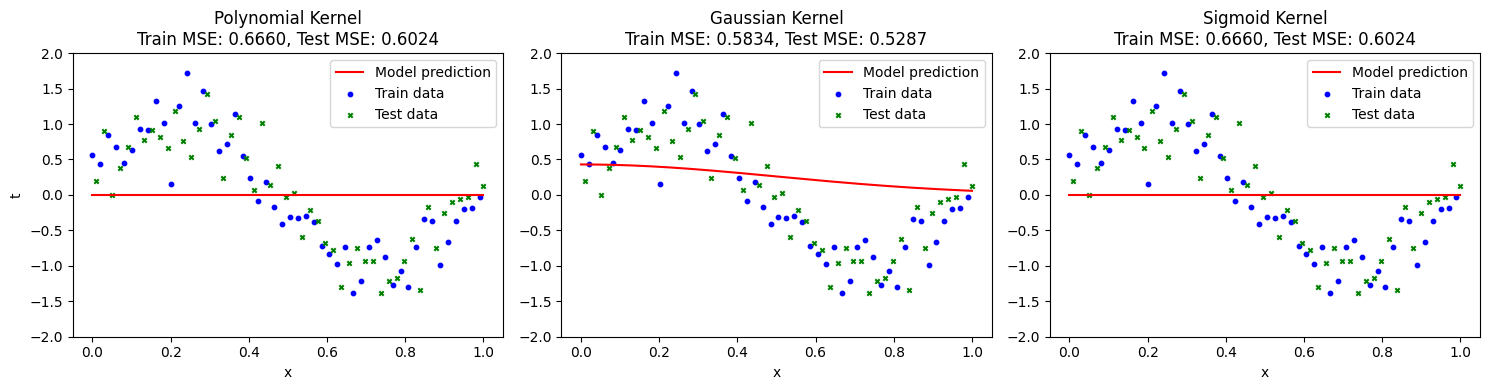


=== Plotting for Model Order M = 1 ===


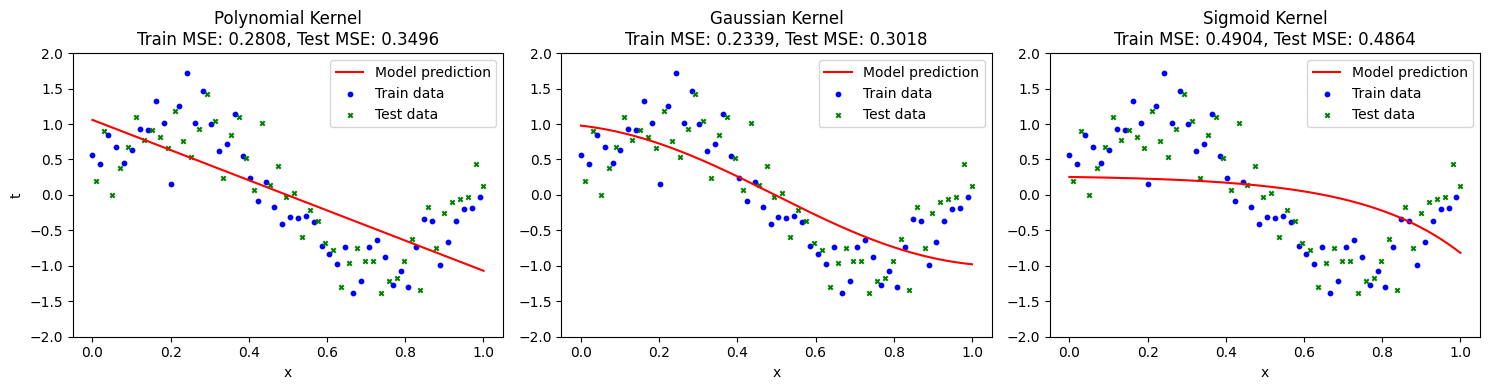


=== Plotting for Model Order M = 2 ===


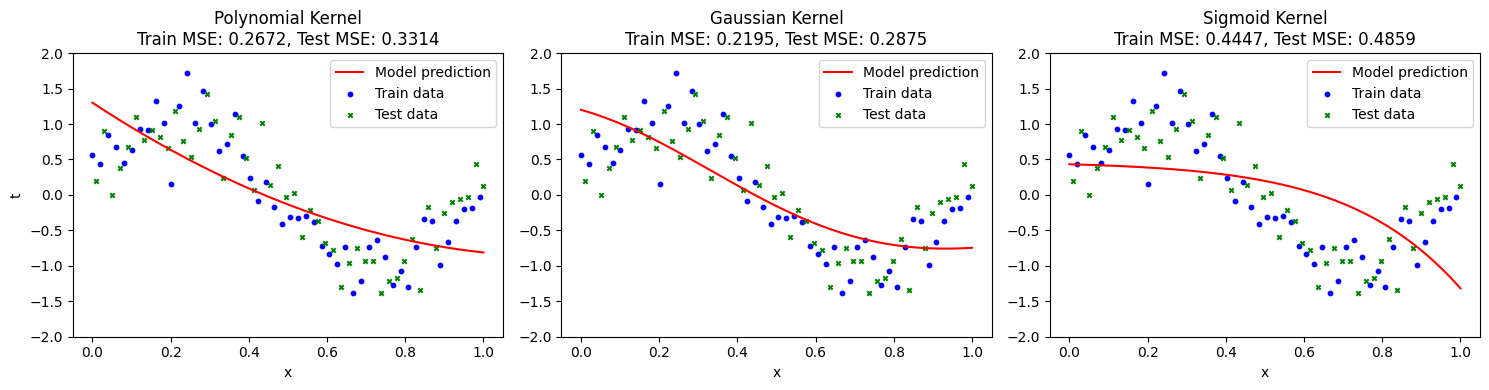


=== Plotting for Model Order M = 3 ===


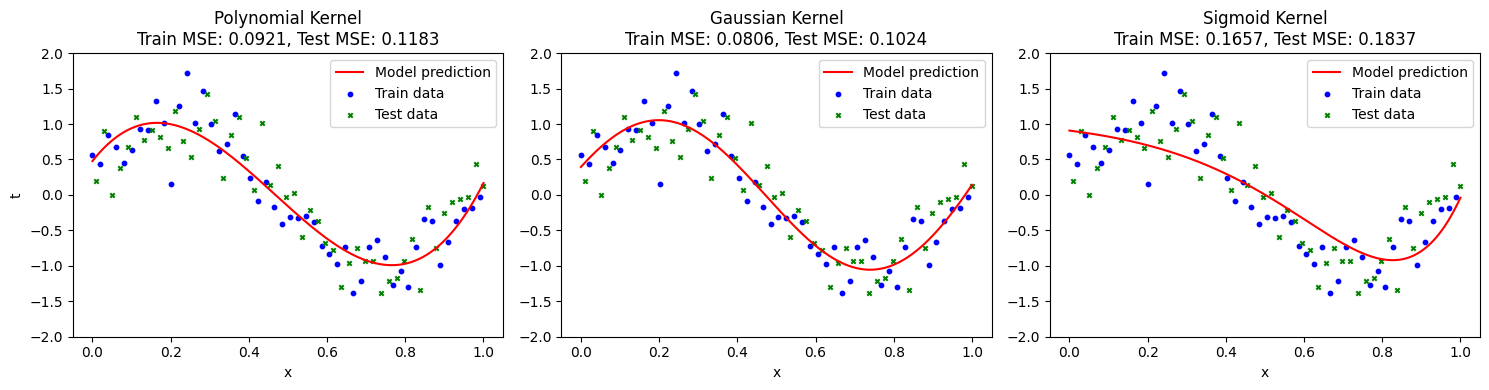


=== Plotting for Model Order M = 4 ===


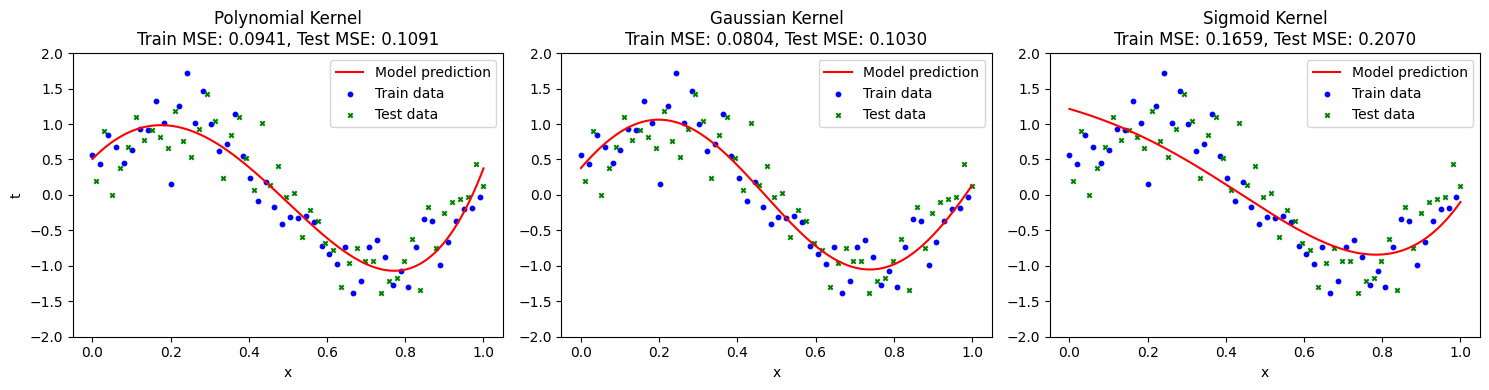


=== Plotting for Model Order M = 5 ===


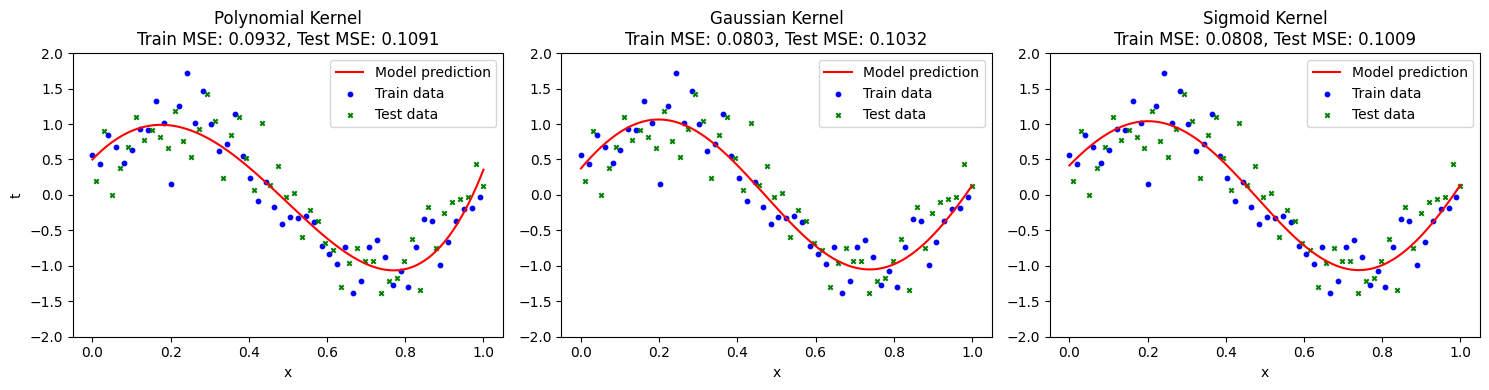


=== Plotting for Model Order M = 6 ===


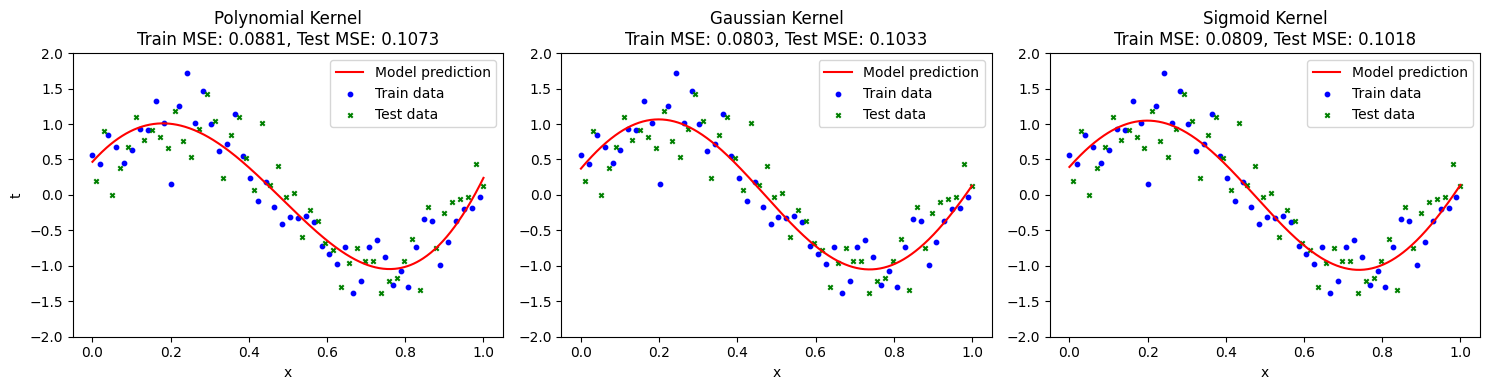


=== Plotting for Model Order M = 7 ===


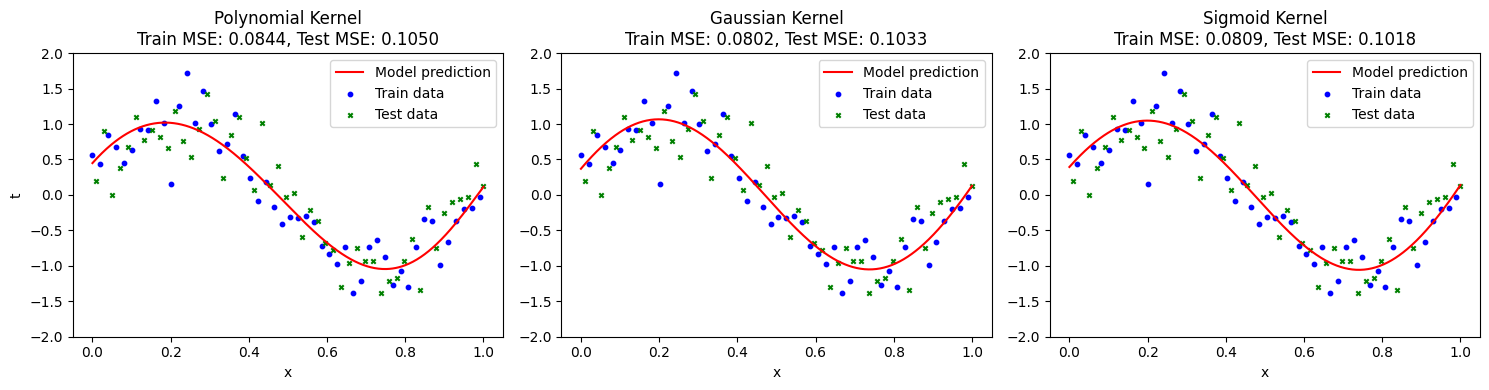


=== Plotting for Model Order M = 8 ===


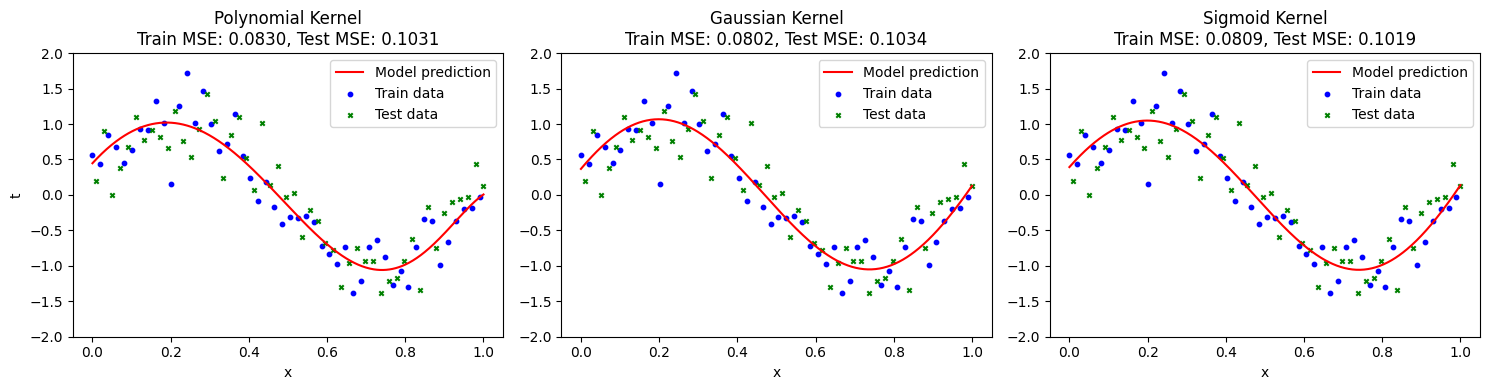


=== Plotting for Model Order M = 9 ===


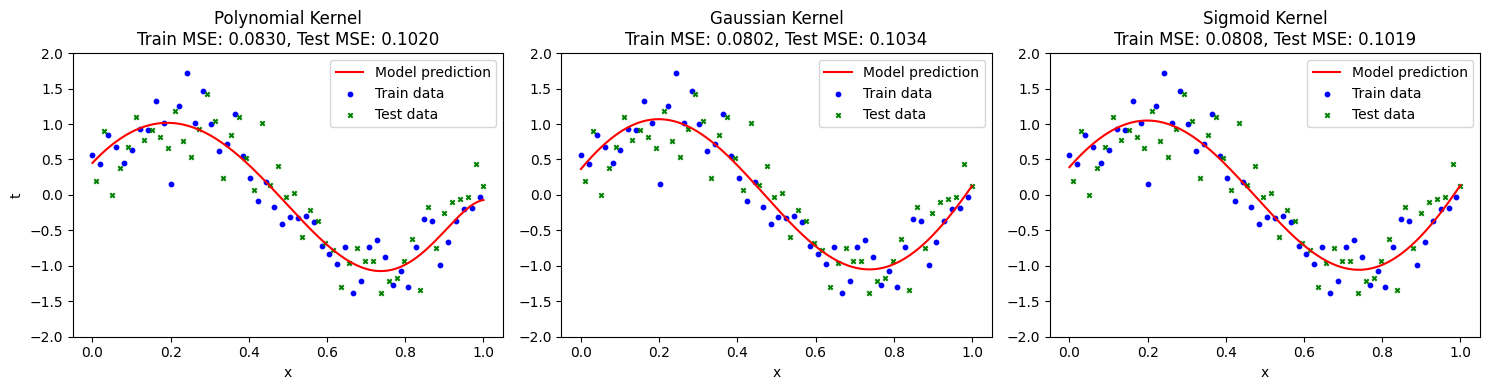

In [7]:
######################
#Plotting predictions
######################

# Visualization points
x_vis = np.linspace(0, 1, 500).reshape(-1, 1)

M_range=list(range(10))

for M in M_range:
    centers = np.linspace(x_train.min(), x_train.max(), M + 1)
    print(f"\n=== Plotting for Model Order M = {M} ===")
    PlotPrediction(x_vis, x_train, t_train, x_test, t_test, M, lamda = 0.01, centers = centers, sigma = 0.3, a=1.0, b=0.0,
                   best_gaussian=best_gaussian,best_poly=best_poly,best_sigmoid=best_sigmoid
                   )

### Observations from Kernel Regression Plots (Model Order M = 0 to 9)

We trained models using **polynomial**, **gaussian**, and **sigmoid** kernels across increasing M, which control the model’s flexibility. Here's what we observed:

**M = 0 to 2: Underfitting**

- All kernels perform poorly at low M  — predictions are almost flat or overly simple.
- Both training and test errors are high.

**M = 3 to 5: Best Performance**

- The models start capturing the underlying sine pattern effectively.
- Train and test errors both drop — models are generalizing well.
- Enough flexibility to model the data, but not so much that it overfits.

**M = 6 to 9: Overfitting**

- Models continue to fit training data well (low train error).
- Predictions stay accurate, but adding more basis functions doesn’t help further.
- More complexity increases risk of overfitting without meaningful improvement.

### Kernel Type Comparison

**Gaussian**
- Smooth and accutate performance.
- It uses small bell-shaped curves that can fit complex patterns really well.

**Polynomial**
- Good for medium M but unstable for high M.
- Changes in one part of input can affect the entire curve, making them unstable and overfitting at high orders.

**Sigmoid**
- Sigmoid functions are smooth but not very flexible at low \( M \); they need more complexity to work well.
- It is like trying to draw a wavy line using only a few S-curves. With 2 or 3, the line will be flat. But with more, we can shape the line however we like by combining those curves.

### Importance of a Validation Set

Currently, we’re selecting the best model based on test error, but:

- Ideally, we should use a validation set (a third, separate split).
- Validation helps tune hyperparameters like M ,lambda ,sigma ,a and b.
- It ensures the test set remains unbiased and only used for final evaluation.

 Without a validation set, we risk overfitting to the test set by indirectly optimizing against it.



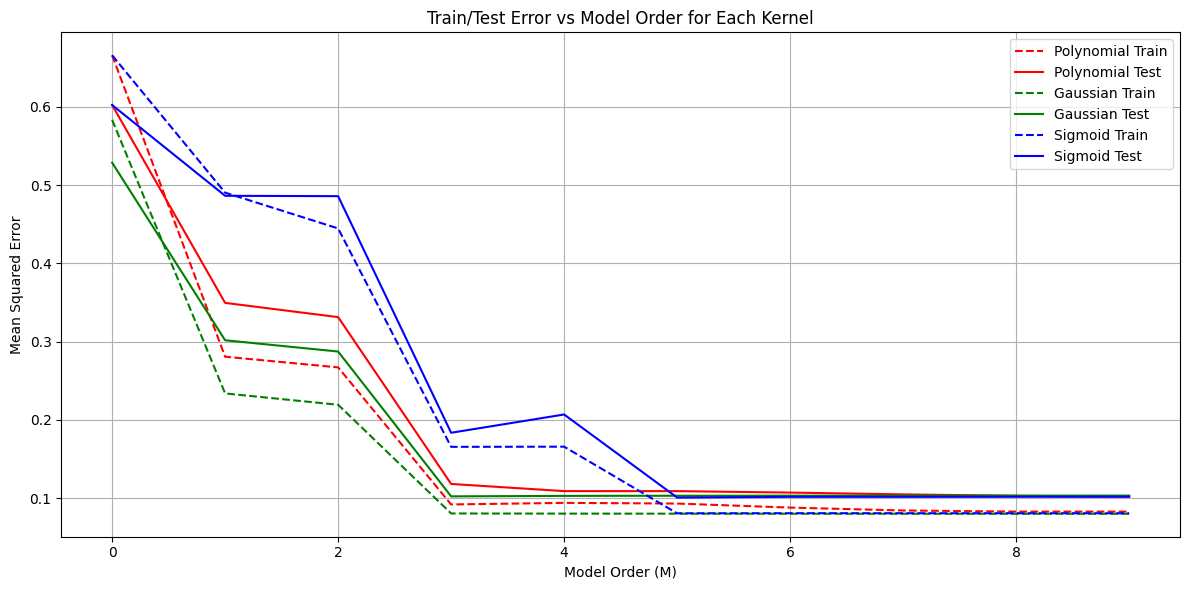

In [8]:
#################
#Plotting Errors
#################

PlotErrors(x_train, t_train, x_test, t_test, lamda = 0.01, sigma = 0.3, a = 1.0, b = 0.0, M_range = range(10), 
           best_sigmoid=best_sigmoid, best_gaussian=best_gaussian, best_poly=best_poly)

### Train/Test Error vs Model Order (M) – Sine Function with Noise

From M = 0 to 5, training and test errors drop for all kernels.
This shows that increasing complexity helps the model learn the sine pattern more accurately.

#### **Gaussian Kernel**
- Performs best overall.
- Lowest training and test error across nearly all values of M.

#### **Polynomial Kernel**
- Performs well, especially at mid-range M.
- Errors flatten out around M = 5, showing it has reached its ideal order.
- Works well for smooth patterns like a sine wave.

#### **Sigmoid Kernel**
- Starts off worse, with higher test error at low M.
- Improves steadily and gets close to Gaussian and Polynomial by higher M.
- Needs more complexity to express the the function.

Hence the choice of kernel and model order should depend on the nature of the target function.


In [9]:
##############################################
#Generating data points for 3(b) and splitting
##############################################

np.random.seed(0)
x_b = np.sort(np.random.uniform(0, 3, 100))
noise_b = np.random.normal(0, np.sqrt(0.1), size=x_b.size)
t_b = np.zeros(x_b.size)

range1 = (x_b >= 0) & (x_b <= 1)
t_b[range1] = np.sin(2 * np.pi * x_b[range1])

# Triangle on (1, 2]
range2 = (x_b > 1) & (x_b <= 2)
# Triangle wave: peak at x=1.5, height=1
t_b[range2] = 1 - 2 * np.abs(x_b[range2] - 1.5)

# Gaussian bump on (2, 3]
range3 = (x_b > 2) & (x_b <= 3)
t_b[range3] = np.exp(-((x_b[range3] - 2.5)**2) / (2 * 0.15**2))
t_b = t_b + noise_b
t_b = t_b.reshape(-1, 1)
x_b = x_b.reshape(-1, 1)

#Take even samples for training and odd samples for testing
xb_train = x_b[::2]
tb_train = t_b[::2]
xb_test = x_b[1::2]
tb_test = t_b[1::2]

In [10]:
#######################
#Hyperparameter tuning 
#######################

best_sigmoid, best_mse_sigmoid = tune_sigmoid(xb_train, tb_train, xb_test, tb_test,9,lambda_values,a_values,b_values)
best_gaussian, best_mse_gaussian = tune_sigma(xb_train, tb_train, xb_test, tb_test, 9,lambda_values,sigma_values)
best_poly = tune_polynomial(xb_train, tb_train, xb_test, tb_test, 9,lambda_values)

Best sigmoid kernel: a=2, b=-5, lambda=4.641588833612782e-05
Test MSE: 0.1442
Best Gaussian kernel params: lambda=1e-05, sigma=0.3
Test MSE: 0.1121
Best λ for Polynomial Kernel = 0.00001 with Test Error = 0.1103



=== Plotting for Model Order M = 0 ===


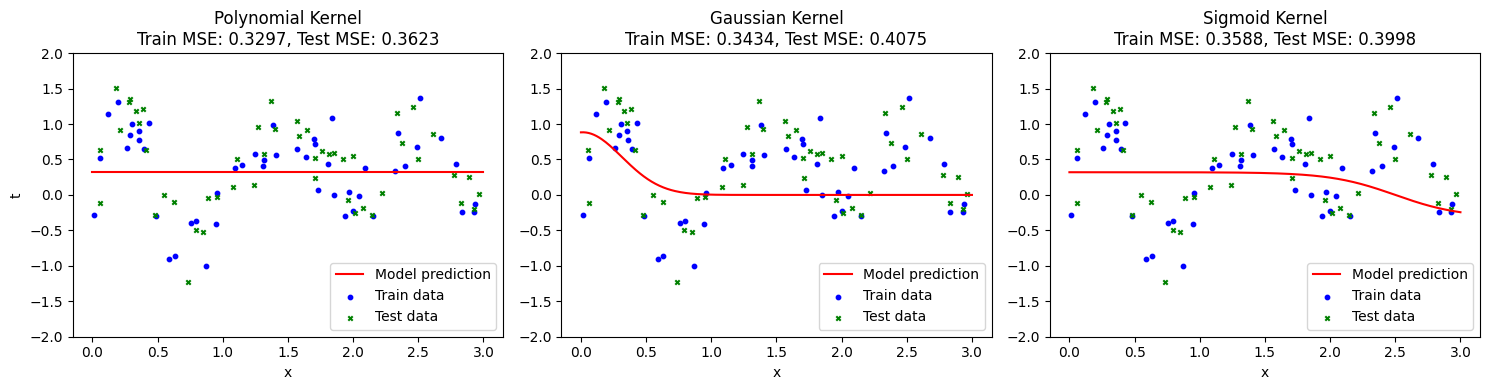


=== Plotting for Model Order M = 1 ===


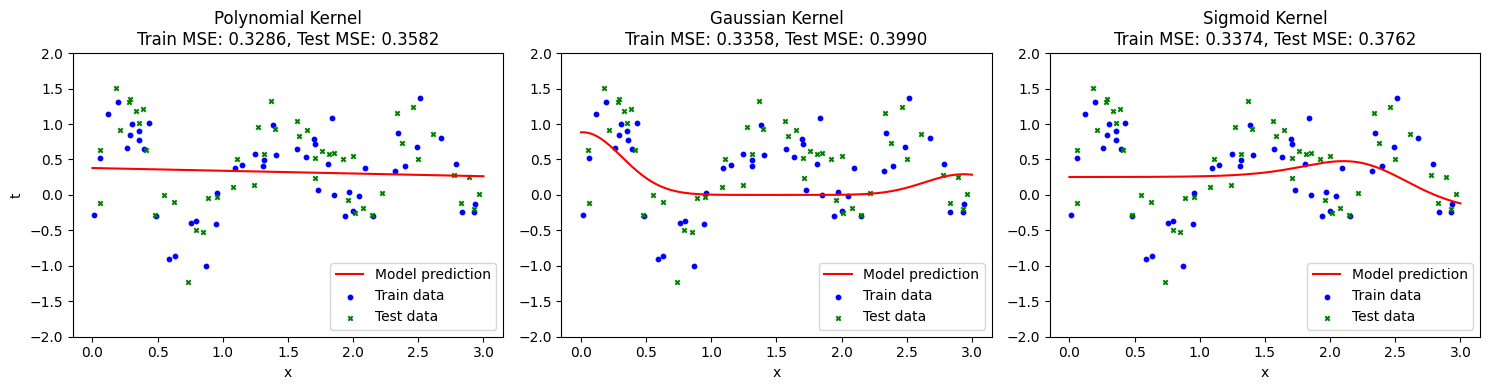


=== Plotting for Model Order M = 2 ===


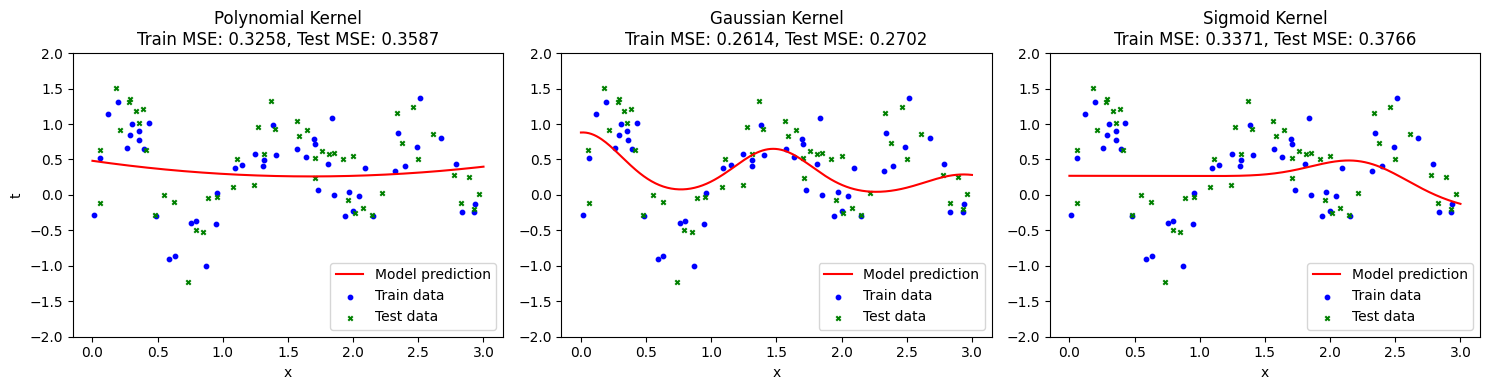


=== Plotting for Model Order M = 3 ===


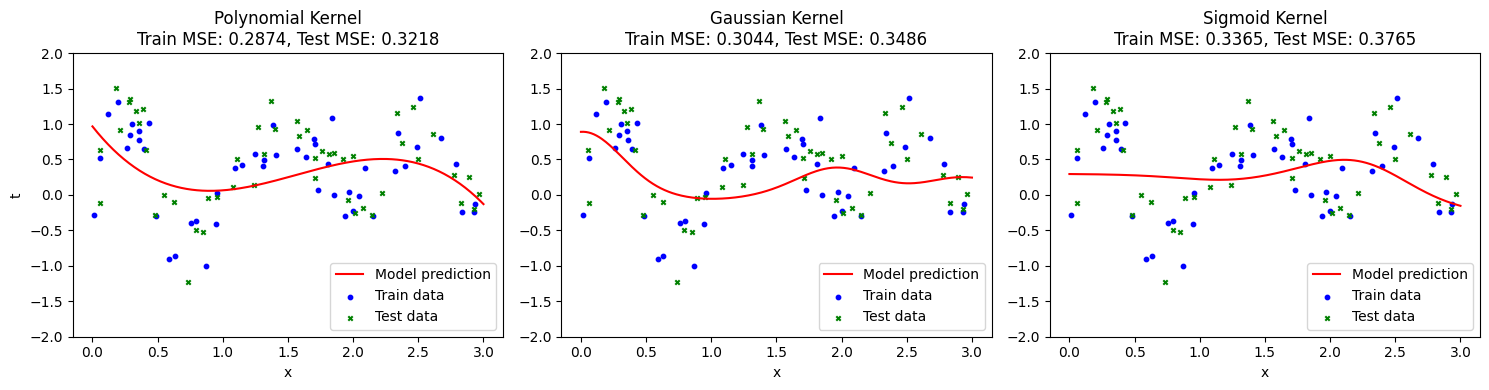


=== Plotting for Model Order M = 4 ===


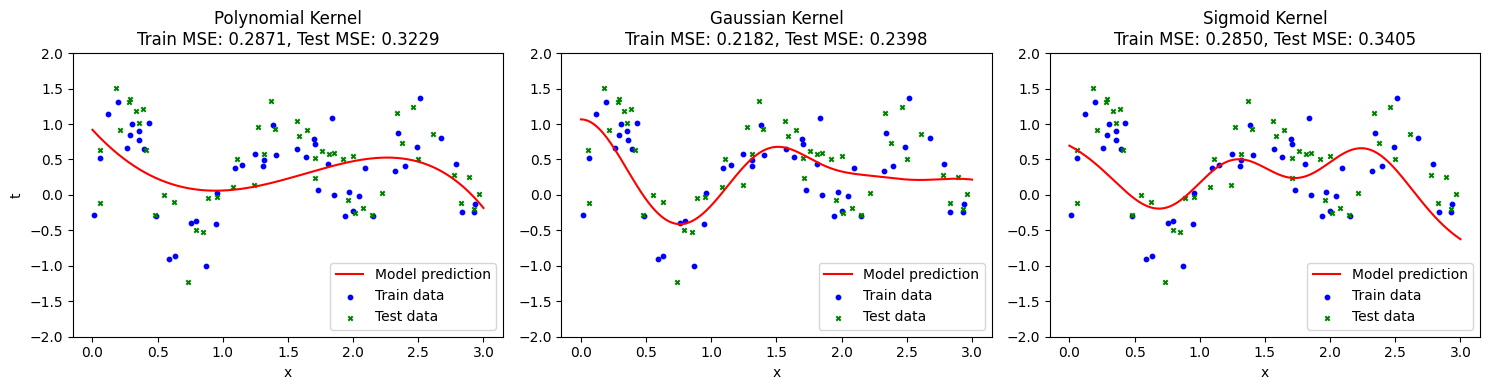


=== Plotting for Model Order M = 5 ===


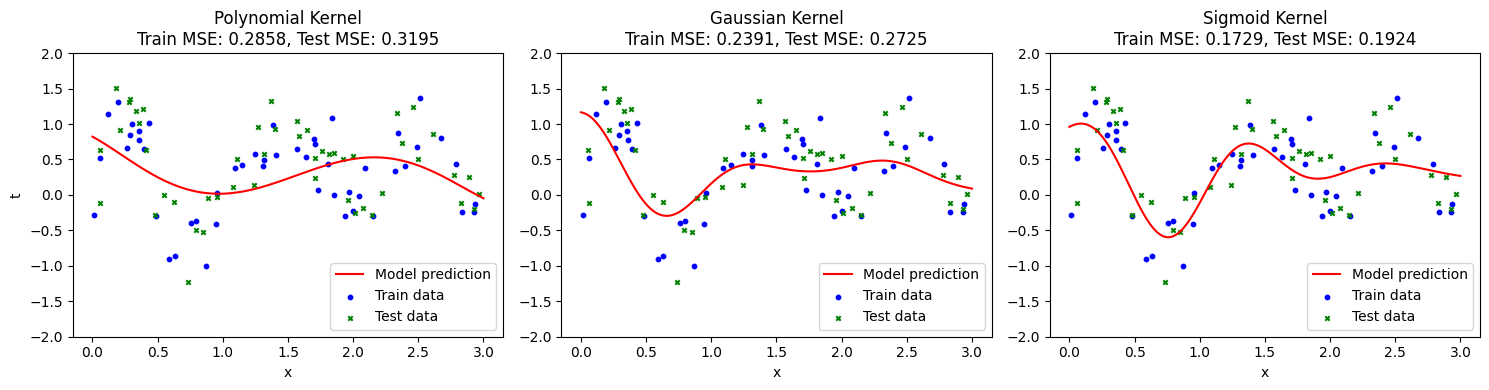


=== Plotting for Model Order M = 6 ===


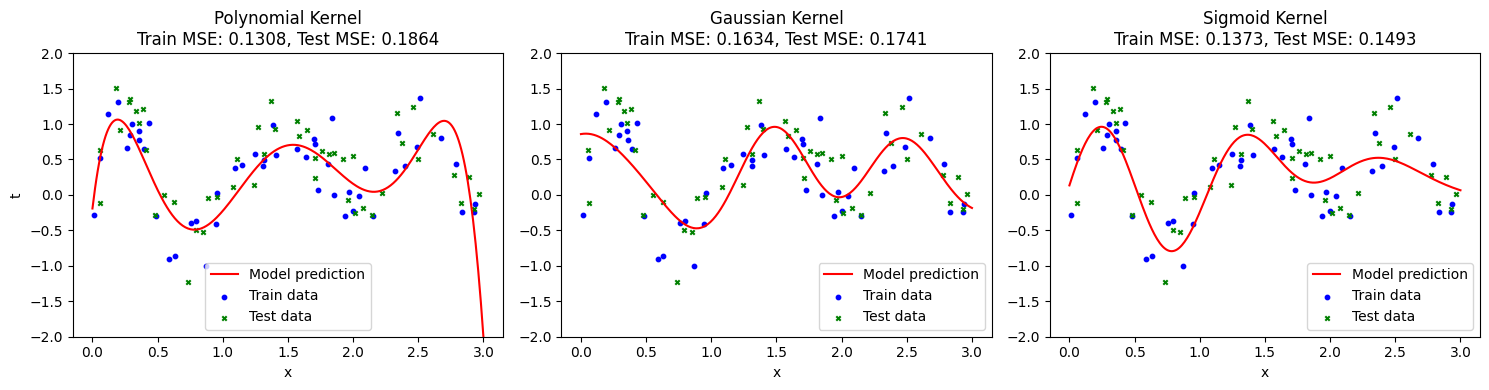


=== Plotting for Model Order M = 7 ===


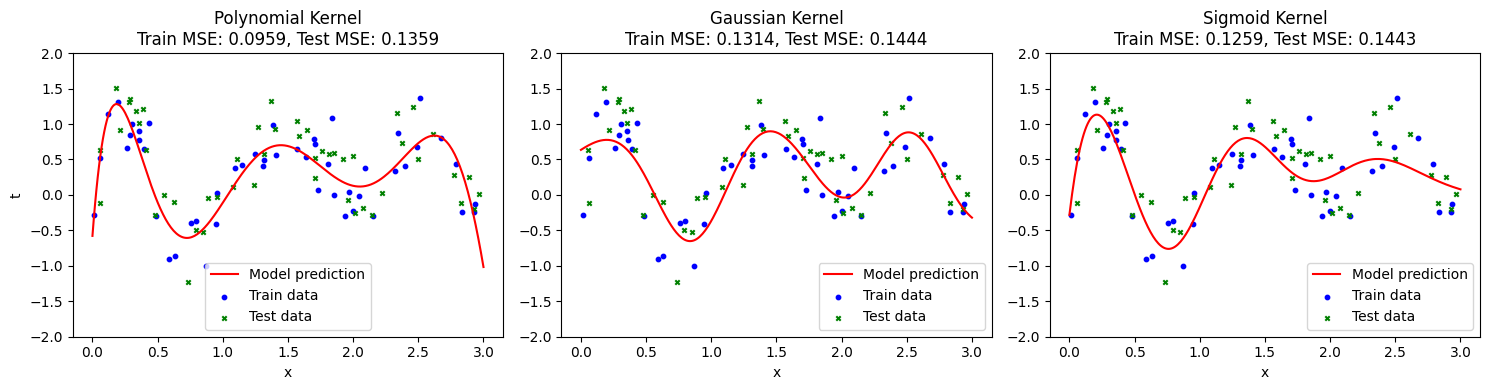


=== Plotting for Model Order M = 8 ===


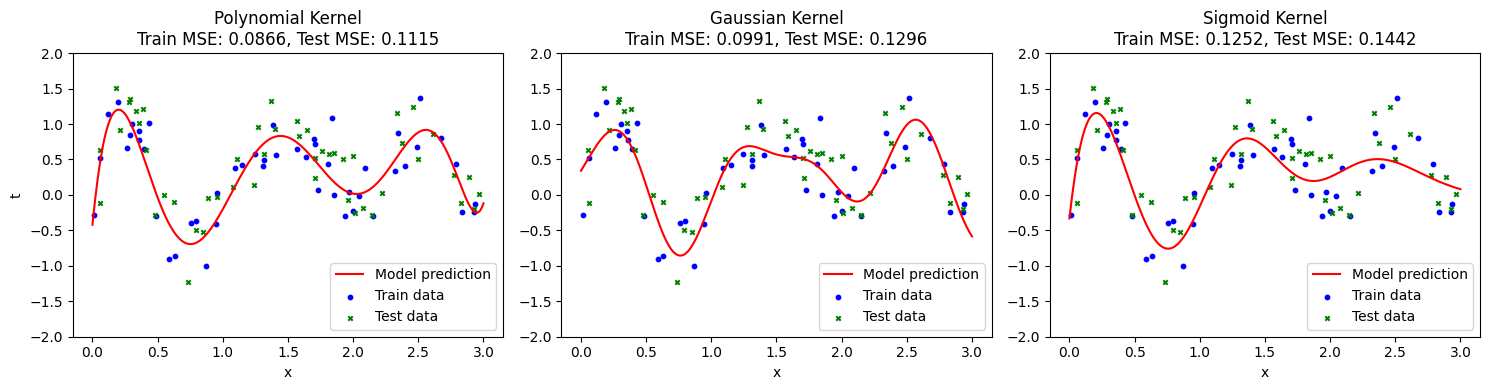


=== Plotting for Model Order M = 9 ===


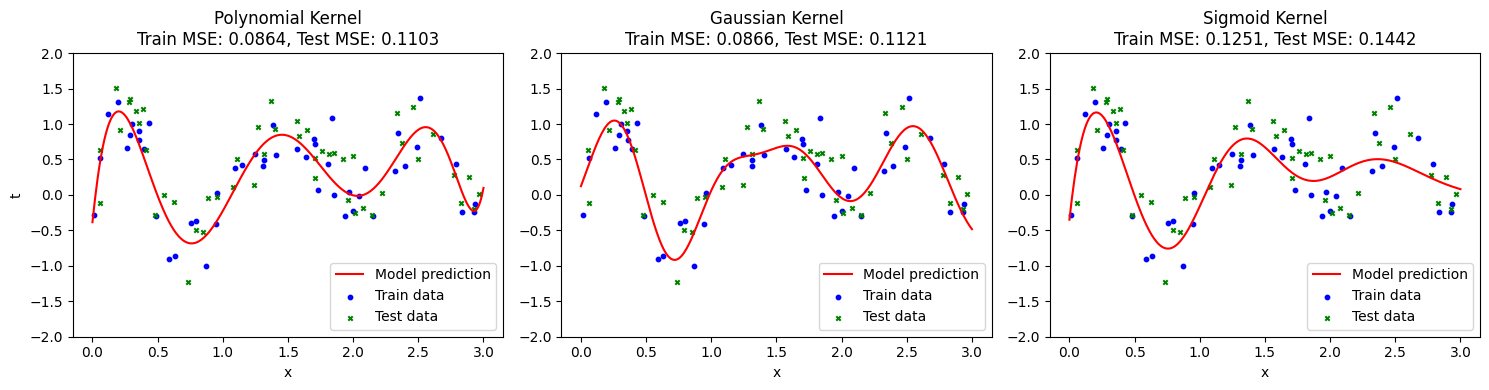

In [11]:
#####################
#Plotting predictions
#####################

x_vis = np.linspace(0, 3, 300).reshape(-1, 1)

for M in M_range:
    centers = np.linspace(xb_train.min(), xb_train.max(), M + 1)
    print(f"\n=== Plotting for Model Order M = {M} ===")
    PlotPrediction(x_vis, xb_train, tb_train, xb_test, tb_test, M, lamda=0.01, centers=centers, sigma = 0.15, a=1.0, b=0.0,
                   best_gaussian=best_gaussian,best_poly=best_poly,best_sigmoid=best_sigmoid                   
                   )

### Comparing Observations Across Two Different Target Functions

The model behavior changes significantly due to this more complex structure.

### Key Differences in Behavior

#### 1. **Higher Overall Errors**
- The mean squared errors are generally higher for all kernels, especially at lower M.
- This is because the new function has more small and abrupt changes, making it harder to approximate with fewer basis functions.

#### 2. **Polynomial Kernel**
- Polynomial kernels do okay at moderate M, but start to overfit and show wavy, unstable behavior earlier.
- Their global nature makes them poorly suited for sharp local features like the triangle peak or Gaussian bump.
- Runge phenomenon : When interpolating a smooth function over a large interval using high-degree polynomials with equally spaced points, the resulting polynomial may oscillate wildly near the endpoints, even though it fits the points exactly.

#### 3. **Gaussian Kernel**
- Gaussian kernels perform consistently well.
- They work best here because they are can adapt to small regions independently.
- Starts to overfit for M=8,9 as the difference between train and test errors increases

#### 4. **Sigmoid Kernel**
- As before, sigmoid kernels start off slow but improve with higher M.

### Conclusion

- The kind of target function you’re trying to learn really affects which kernel works best.

- If the function is smooth and changes gradually, simpler models like polynomials can work well.

- But if the function has sharp turns, bumps, or different patterns in different regions, you need something more flexible like Gaussian kernels that can adapt to local changes.

- Sigmoid kernels are also flexible, but they usually need a more complex model (higher M) to capture all the details properly.

This shows why testing on different kinds of functions is important when choosing the right kernel and model complexity.


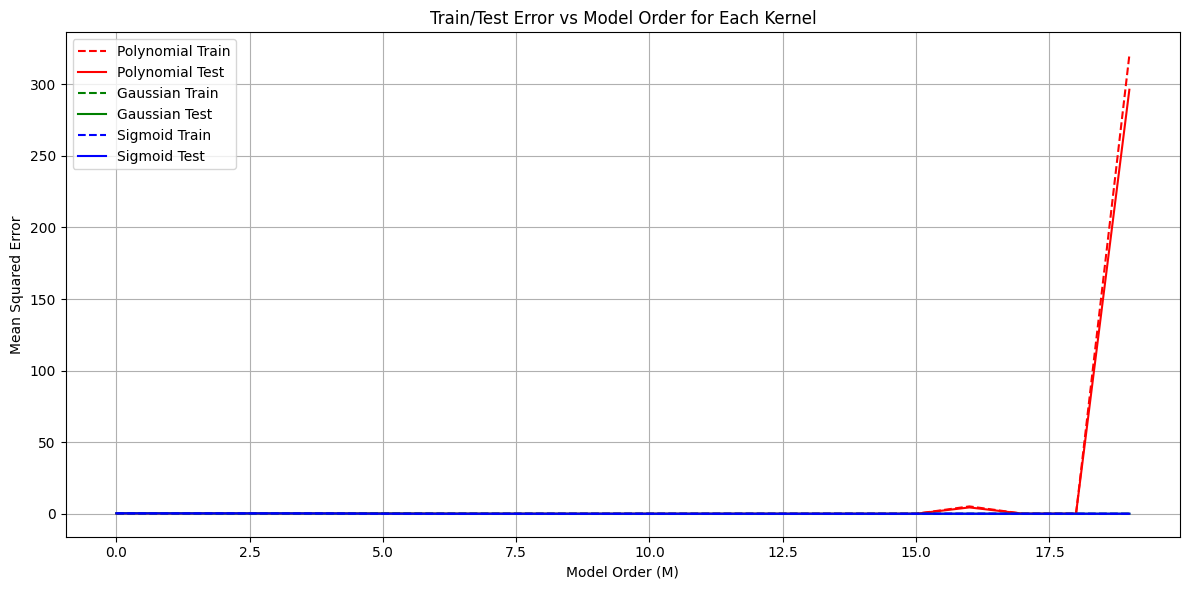

In [12]:
#################
#Plotting errors
#################

PlotErrors(xb_train, tb_train, xb_test, tb_test, lamda= 0.01, sigma = 0.3, a = 1.0, b = 0.0, M_range = range(20),
           best_gaussian=best_gaussian, best_sigmoid=best_sigmoid,best_poly=best_poly
           )

### Train/Test Error vs Model Order (M) – Piecewise Target Function

Train and test errors decrease steadily, meaning the models are learning the underlying pattern as complexity increases.

#### **Polynomial Kernel**
- Initially performs reasonably well.
- But after M = 13 , both training and test errors suddenly increase and oscillate.
- Runge phenomenon can be observed more clearly here.
- This sharp increase was only visible after we extended the model order range from 10 to 20. Before that, the polynomial kernel appeared to perform similarly to the others.

#### **Gaussian Kernel**
- Maintains consistently low errors across all M.
- Can be suitable for piecewise or irregular target functions.

#### **Sigmoid Kernel**
- Has slightly higher error than Gaussian, but stays stable and smooth.

### Conclusion

- **Gaussian kernels** are the most robust across varying complexity — they model local features without instability.
- **Polynomial kernels** may suddenly overfit at higher orders, so always test a wide range of M.
- **Sigmoid kernels** offer smooth performance and are less risky than polynomials for irregular data.
